# Checkpoint 3: Policy Gradients and REINFORCE

In this notebook, we'll implement the REINFORCE algorithm from scratch using PyTorch. This is a foundational policy gradient method that directly learns a policy without requiring a value function.

**Learning Objectives:**
- Understand the difference between value-based and policy-based methods
- Learn the Policy Gradient Theorem
- Implement the REINFORCE algorithm
- Train an agent to solve CartPole-v1

In [1]:
# Install required dependencies
!pip install gymnasium[classic-control] torch numpy matplotlib --quiet


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# GPU Detection
import torch

def get_device():
    """Detect and return the best available device."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"CUDA GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"CUDA version: {torch.version.cuda}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Apple Silicon MPS device detected")
    else:
        device = torch.device("cpu")
        print("No GPU detected, using CPU")
    
    print(f"PyTorch version: {torch.__version__}")
    print(f"Selected device: {device}")
    return device

device = get_device()

CUDA GPU detected: NVIDIA GeForce RTX 3090
CUDA version: 12.4
PyTorch version: 2.4.1+cu124
Selected device: cuda


In [3]:
# Imports
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

print("All imports successful!")
print(f"Gymnasium version: {gym.__version__}")

All imports successful!
Gymnasium version: 1.2.3


## Theory: Value-Based vs Policy-Based Methods

So far, we've seen **value-based methods** like Q-learning that learn a value function and derive a policy from it. Now we'll explore **policy-based methods** that directly learn the policy.

| Aspect | Value-Based (e.g., DQN) | Policy-Based (e.g., REINFORCE) |
|--------|-------------------------|--------------------------------|
| **Learns** | Value function Q(s,a) | Policy directly $\pi_\theta(a|s)$ |
| **Policy** | Implicit (argmax over Q) | Explicit (parameterized) |
| **Action Space** | Discrete only | Discrete or Continuous |
| **Convergence** | Can oscillate | Smoother, but high variance |
| **Exploration** | epsilon-greedy | Natural via stochastic policy |
| **Sample Efficiency** | More efficient (replay buffer) | Less efficient (on-policy) |

### Why Policy Gradients?

1. **Continuous Actions**: Policy gradients naturally handle continuous action spaces
2. **Stochastic Policies**: Can learn truly stochastic policies (useful in games)
3. **Simpler**: Sometimes easier to optimize the policy directly
4. **Convergence Guarantees**: Better theoretical convergence properties

## Theory: The Policy Gradient Theorem

### Objective

We want to find policy parameters $\theta$ that maximize expected return:

$$J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}[R(\tau)]$$

where $\tau$ is a trajectory and $R(\tau)$ is the total return.

### The Policy Gradient Theorem

The gradient of the objective is:

$$\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta}\left[\sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t\right]$$

where $G_t = \sum_{k=t}^{T} \gamma^{k-t} r_k$ is the return from timestep $t$.

### Intuition

- **$\nabla_\theta \log \pi_\theta(a_t|s_t)$**: Direction to increase probability of action $a_t$
- **$G_t$**: How good was this action (the return)
- **Product**: Increase probability of good actions, decrease bad ones

### The Log Trick

The key insight is the "log-derivative trick":

$$\nabla_\theta \pi_\theta(a|s) = \pi_\theta(a|s) \cdot \nabla_\theta \log \pi_\theta(a|s)$$

This allows us to write the gradient as an expectation we can sample!

## Theory: REINFORCE Algorithm

REINFORCE is a Monte Carlo policy gradient algorithm that uses complete episode returns.

### Pseudocode

```
Initialize policy network pi_theta with random weights
Initialize optimizer

for episode = 1 to num_episodes:
    # Collect trajectory
    states, actions, rewards, log_probs = [], [], [], []
    state = env.reset()
    
    while not done:
        # Sample action from policy
        action_probs = pi_theta(state)
        action = sample from Categorical(action_probs)
        log_prob = log(action_probs[action])
        
        # Take action
        next_state, reward, done = env.step(action)
        
        # Store trajectory
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)
        
        state = next_state
    
    # Compute returns G_t for each timestep
    returns = compute_returns(rewards, gamma)
    
    # Compute policy gradient loss
    loss = 0
    for log_prob, G_t in zip(log_probs, returns):
        loss += -log_prob * G_t  # Negative for gradient ascent
    
    # Update policy
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

### Key Points

1. **Monte Carlo**: Uses complete episodes (no bootstrapping)
2. **On-Policy**: Must use fresh samples from current policy
3. **High Variance**: Returns can vary significantly episode to episode

In [4]:
class PolicyNetwork(nn.Module):
    """
    A simple policy network that outputs action probabilities.
    
    Architecture:
        Input -> Linear(128) -> ReLU -> Linear(128) -> ReLU -> Linear(n_actions) -> Softmax
    """
    
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        
    def forward(self, state):
        """Forward pass returning action probabilities."""
        return self.network(state)
    
    def select_action(self, state):
        """
        Select an action by sampling from the policy distribution.
        
        Returns:
            action: The selected action
            log_prob: Log probability of the selected action
        """
        # Convert state to tensor if needed
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        # Get action probabilities
        action_probs = self.forward(state)
        
        # Create categorical distribution and sample
        dist = Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        
        return action.item(), log_prob

# Test the network
test_env = gym.make("CartPole-v1")
state_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.n

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")

test_policy = PolicyNetwork(state_dim, action_dim).to(device)
test_state, _ = test_env.reset()
action, log_prob = test_policy.select_action(test_state)
print(f"\nTest action: {action}, Log probability: {log_prob.item():.4f}")

test_env.close()

State dimension: 4
Action dimension: 2

Test action: 0, Log probability: -0.6736


In [5]:
def compute_returns(rewards, gamma=0.99, normalize=True):
    """
    Compute discounted returns for each timestep.
    
    Args:
        rewards: List of rewards from the episode
        gamma: Discount factor (default: 0.99)
        normalize: Whether to normalize returns (default: True)
        
    Returns:
        Tensor of discounted returns
    """
    returns = []
    G = 0
    
    # Calculate returns from end to start
    for reward in reversed(rewards):
        G = reward + gamma * G
        returns.insert(0, G)
    
    returns = torch.tensor(returns, dtype=torch.float32).to(device)
    
    # Normalize returns to reduce variance
    if normalize and len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    
    return returns

# Test the function
test_rewards = [1, 1, 1, 1, 1]  # 5 timesteps, all reward 1
test_returns = compute_returns(test_rewards, gamma=0.99, normalize=False)
print("Test rewards:", test_rewards)
print("Discounted returns (G_t for each t):")
for t, G in enumerate(test_returns):
    print(f"  t={t}: G_{t} = {G.item():.4f}")

Test rewards: [1, 1, 1, 1, 1]
Discounted returns (G_t for each t):
  t=0: G_0 = 4.9010
  t=1: G_1 = 3.9404
  t=2: G_2 = 2.9701
  t=3: G_3 = 1.9900
  t=4: G_4 = 1.0000


In [6]:
def train_reinforce(env, policy, optimizer, num_episodes=500, gamma=0.99, print_every=50):
    """
    Train a policy using the REINFORCE algorithm.
    
    Args:
        env: Gymnasium environment
        policy: PolicyNetwork
        optimizer: PyTorch optimizer
        num_episodes: Number of training episodes
        gamma: Discount factor
        print_every: How often to print progress
        
    Returns:
        episode_rewards: List of total rewards per episode
    """
    episode_rewards = []
    recent_rewards = deque(maxlen=100)
    
    for episode in range(num_episodes):
        # Storage for episode data
        log_probs = []
        rewards = []
        
        # Reset environment
        state, _ = env.reset()
        done = False
        truncated = False
        
        # Collect trajectory
        while not done and not truncated:
            # Select action
            action, log_prob = policy.select_action(state)
            
            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            
            # Store data
            log_probs.append(log_prob)
            rewards.append(reward)
            
            state = next_state
        
        # Compute returns
        returns = compute_returns(rewards, gamma)
        
        # Compute policy gradient loss
        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            # Negative because we want gradient ascent
            policy_loss.append(-log_prob * G)
        
        # Sum up the losses
        loss = torch.stack(policy_loss).sum()
        
        # Update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track rewards
        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)
        recent_rewards.append(episode_reward)
        
        # Print progress
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(recent_rewards)
            print(f"Episode {episode + 1}/{num_episodes} | "
                  f"Avg Reward (last 100): {avg_reward:.2f} | "
                  f"Episode Reward: {episode_reward:.2f}")
        
        # Check if solved (CartPole is solved at 475 average over 100 episodes)
        if len(recent_rewards) >= 100 and np.mean(recent_rewards) >= 475:
            print(f"\nEnvironment solved in {episode + 1} episodes!")
            print(f"Average reward over last 100 episodes: {np.mean(recent_rewards):.2f}")
            break
    
    return episode_rewards

print("Training function defined!")

Training function defined!


In [7]:
# Create environment and policy
env = gym.make("CartPole-v1")

# Initialize policy network
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy = PolicyNetwork(state_dim, action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

print("Policy Network Architecture:")
print(policy)
print(f"\nTotal parameters: {sum(p.numel() for p in policy.parameters())}")

# Train the agent
print("\n" + "="*60)
print("Starting REINFORCE Training on CartPole-v1")
print("="*60 + "\n")

episode_rewards = train_reinforce(
    env=env,
    policy=policy,
    optimizer=optimizer,
    num_episodes=500,
    gamma=0.99,
    print_every=50
)

print("\nTraining complete!")

Policy Network Architecture:
PolicyNetwork(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

Total parameters: 17410

Starting REINFORCE Training on CartPole-v1

Episode 50/500 | Avg Reward (last 100): 36.40 | Episode Reward: 19.00
Episode 100/500 | Avg Reward (last 100): 44.15 | Episode Reward: 84.00
Episode 150/500 | Avg Reward (last 100): 59.18 | Episode Reward: 90.00
Episode 200/500 | Avg Reward (last 100): 86.64 | Episode Reward: 114.00
Episode 250/500 | Avg Reward (last 100): 108.99 | Episode Reward: 114.00
Episode 300/500 | Avg Reward (last 100): 127.76 | Episode Reward: 174.00
Episode 350/500 | Avg Reward (last 100): 189.78 | Episode Reward: 170.00
Episode 400/500 | Avg Reward (last 100): 233.65 | Episode Reward: 201.00
Episode 450/500 | Avg Reward (last 100):

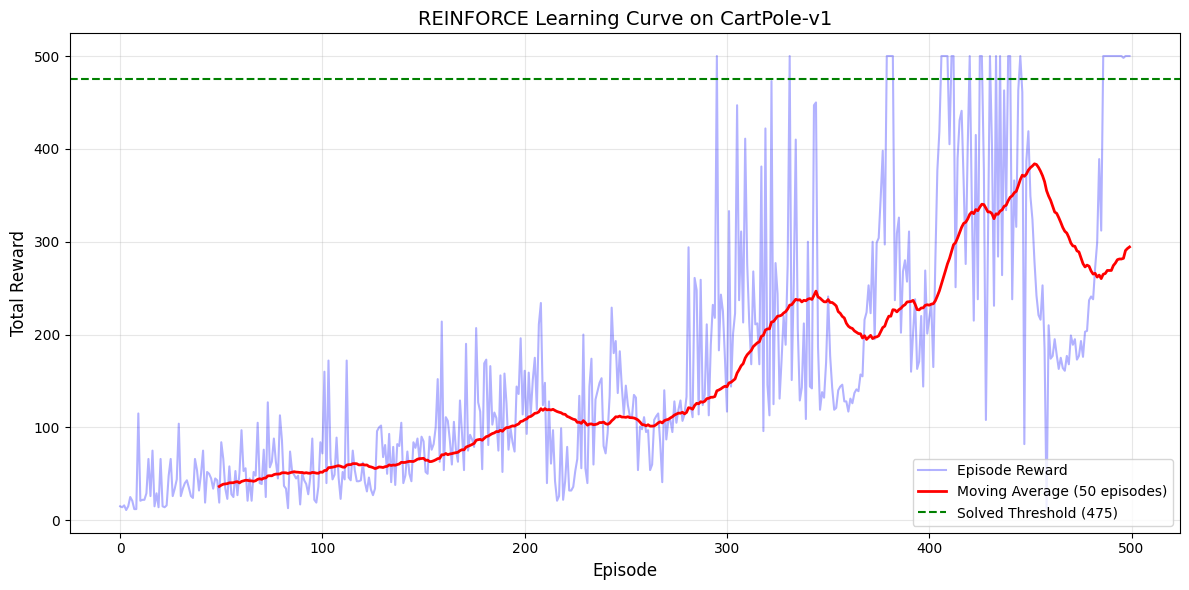


Training Statistics:
  Total episodes: 500
  Max reward: 500.00
  Final 100-episode average: 335.76


In [8]:
# Plot learning curve
def plot_learning_curve(rewards, window=50):
    """
    Plot the learning curve with a moving average.
    
    Args:
        rewards: List of episode rewards
        window: Window size for moving average
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot raw rewards
    ax.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
    
    # Calculate and plot moving average
    if len(rewards) >= window:
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(rewards)), moving_avg, color='red', 
                linewidth=2, label=f'Moving Average ({window} episodes)')
    
    # Add solved threshold line
    ax.axhline(y=475, color='green', linestyle='--', label='Solved Threshold (475)')
    
    ax.set_xlabel('Episode', fontsize=12)
    ax.set_ylabel('Total Reward', fontsize=12)
    ax.set_title('REINFORCE Learning Curve on CartPole-v1', fontsize=14)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nTraining Statistics:")
    print(f"  Total episodes: {len(rewards)}")
    print(f"  Max reward: {max(rewards):.2f}")
    print(f"  Final 100-episode average: {np.mean(rewards[-100:]):.2f}")

plot_learning_curve(episode_rewards)

In [9]:
# Test the trained policy with frame capture
def test_policy_with_frames(policy, env_name="CartPole-v1", num_episodes=1, max_steps=500):
    """
    Test the trained policy and capture frames.
    
    Args:
        policy: Trained PolicyNetwork
        env_name: Name of the environment
        num_episodes: Number of test episodes
        max_steps: Maximum steps per episode
        
    Returns:
        frames: List of captured frames
        total_reward: Total reward achieved
    """
    # Create environment with rgb_array render mode
    test_env = gym.make(env_name, render_mode="rgb_array")
    
    frames = []
    total_rewards = []
    
    policy.eval()  # Set to evaluation mode
    
    with torch.no_grad():
        for episode in range(num_episodes):
            state, _ = test_env.reset()
            episode_reward = 0
            done = False
            truncated = False
            step = 0
            
            while not done and not truncated and step < max_steps:
                # Capture frame
                frame = test_env.render()
                frames.append(frame)
                
                # Select action (greedy - take most probable action)
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action_probs = policy(state_tensor)
                action = torch.argmax(action_probs, dim=1).item()
                
                # Take action
                state, reward, done, truncated, _ = test_env.step(action)
                episode_reward += reward
                step += 1
            
            total_rewards.append(episode_reward)
            print(f"Episode {episode + 1}: Reward = {episode_reward}, Steps = {step}")
    
    test_env.close()
    policy.train()  # Set back to training mode
    
    return frames, total_rewards

print("Testing trained policy...\n")
frames, test_rewards = test_policy_with_frames(policy, num_episodes=3)
print(f"\nAverage test reward: {np.mean(test_rewards):.2f}")
print(f"Total frames captured: {len(frames)}")

Testing trained policy...

Episode 1: Reward = 500.0, Steps = 500
Episode 2: Reward = 500.0, Steps = 500
Episode 3: Reward = 500.0, Steps = 500

Average test reward: 500.00
Total frames captured: 1500


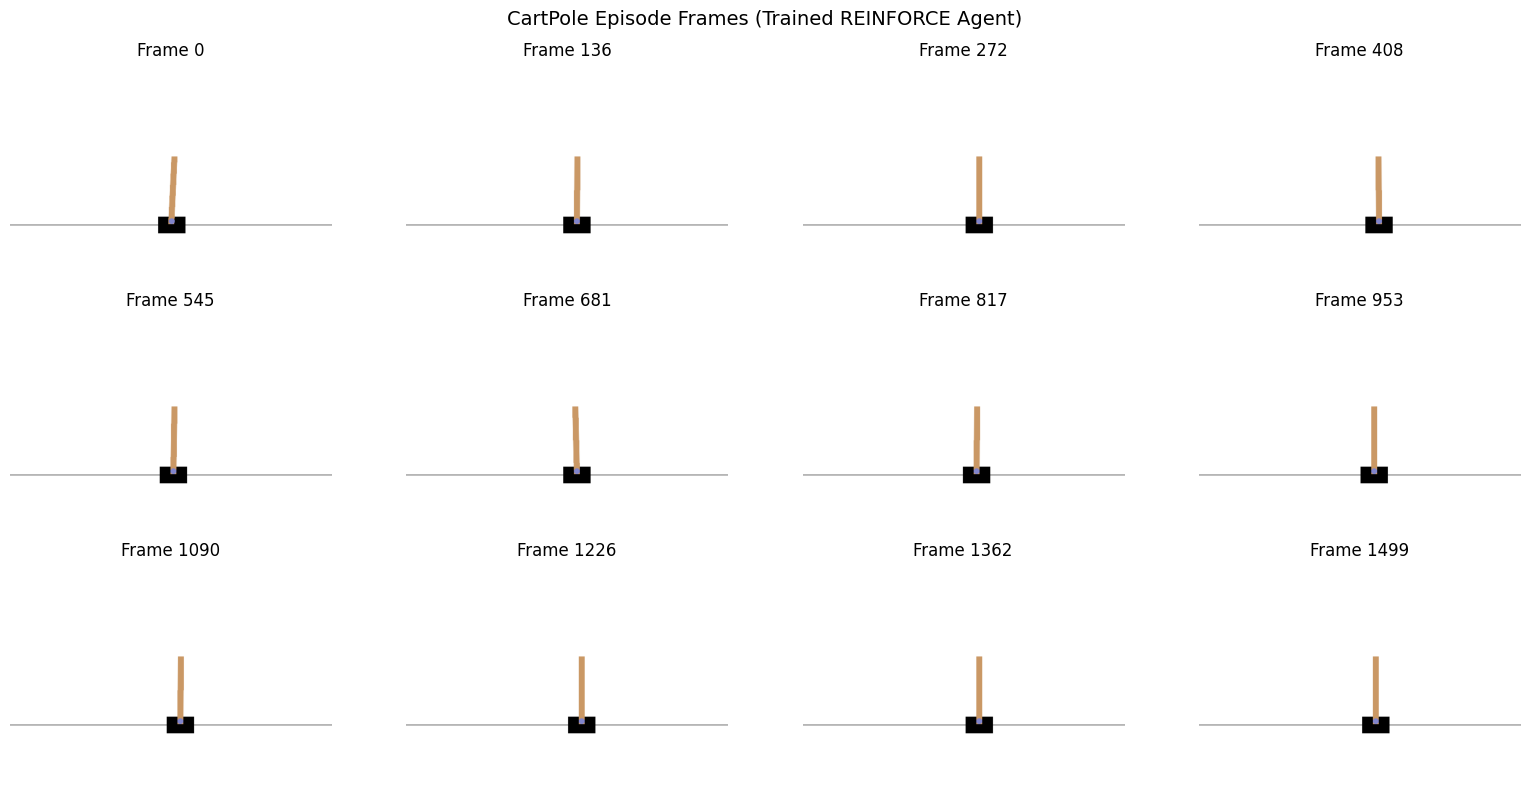

In [10]:
# Display test episode frames
def display_frames(frames, num_frames=12, figsize=(16, 8)):
    """
    Display a selection of frames from the episode.
    
    Args:
        frames: List of RGB frames
        num_frames: Number of frames to display
        figsize: Figure size
    """
    if len(frames) == 0:
        print("No frames to display!")
        return
    
    # Select evenly spaced frames
    indices = np.linspace(0, len(frames) - 1, num_frames, dtype=int)
    selected_frames = [frames[i] for i in indices]
    
    # Create subplot grid
    cols = 4
    rows = (num_frames + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    for i, (ax, frame) in enumerate(zip(axes, selected_frames)):
        ax.imshow(frame)
        ax.set_title(f'Frame {indices[i]}')
        ax.axis('off')
    
    # Hide empty subplots
    for i in range(len(selected_frames), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('CartPole Episode Frames (Trained REINFORCE Agent)', fontsize=14)
    plt.tight_layout()
    plt.show()

display_frames(frames, num_frames=12)

## Quiz: Policy Gradients and REINFORCE

Test your understanding of the concepts covered in this notebook.

---

**Question 1:** What is the main advantage of policy-based methods over value-based methods?

A) They are always faster to train  
B) They can naturally handle continuous action spaces  
C) They require less memory  
D) They always converge to the optimal policy  

<details>
<summary>Click for answer</summary>

**B) They can naturally handle continuous action spaces**

Policy-based methods parameterize the policy directly, making it straightforward to output continuous actions. Value-based methods like DQN require computing Q-values for all actions, which is problematic for continuous spaces.
</details>

---

**Question 2:** In the REINFORCE algorithm, why do we multiply the log probability by the return?

A) To normalize the gradients  
B) To weight the gradient update by how good the action was  
C) To prevent exploding gradients  
D) To speed up convergence  

<details>
<summary>Click for answer</summary>

**B) To weight the gradient update by how good the action was**

The return G_t acts as a weight that tells us how good taking action a_t was. Actions that led to high returns will have their probabilities increased more than actions with low returns.
</details>

---

**Question 3:** Why is REINFORCE considered a high-variance algorithm?

A) Because it uses random initialization  
B) Because Monte Carlo returns can vary significantly between episodes  
C) Because of the softmax activation  
D) Because of the Adam optimizer  

<details>
<summary>Click for answer</summary>

**B) Because Monte Carlo returns can vary significantly between episodes**

REINFORCE uses complete episode returns without bootstrapping. These returns can vary significantly depending on the stochastic outcomes of the episode, leading to high variance in gradient estimates.
</details>

---

**Question 4:** What is the purpose of normalizing the returns in REINFORCE?

A) To make the algorithm deterministic  
B) To reduce variance and stabilize training  
C) To ensure all returns are positive  
D) To speed up the forward pass  

<details>
<summary>Click for answer</summary>

**B) To reduce variance and stabilize training**

Normalizing returns (subtracting mean, dividing by std) acts as a simple baseline that reduces variance. It ensures roughly half the actions are reinforced positively and half negatively.
</details>

---

**Question 5:** Why is REINFORCE an "on-policy" algorithm?

A) Because it runs on a single CPU  
B) Because it requires samples from the current policy being optimized  
C) Because it uses online learning  
D) Because it updates after each step  

<details>
<summary>Click for answer</summary>

**B) Because it requires samples from the current policy being optimized**

On-policy algorithms must use data collected by the current policy. Old experiences collected by previous policies cannot be reused, unlike off-policy methods like DQN that use a replay buffer.
</details>

In [11]:
# Cleanup
print("Cleaning up resources...")

# Close the environment
env.close()

# Clear CUDA cache if using GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared")

# Delete large objects
del policy
del optimizer
del episode_rewards
del frames

print("Cleanup complete!")
print("\n" + "="*60)
print("Checkpoint 3 Complete!")
print("="*60)
print("\nKey Takeaways:")
print("1. Policy gradients directly optimize the policy")
print("2. REINFORCE uses Monte Carlo returns for gradient estimation")
print("3. The algorithm has high variance but simple implementation")
print("4. Normalizing returns helps stabilize training")
print("\nNext: Checkpoint 4 - PPO for more stable policy optimization!")

Cleaning up resources...
CUDA cache cleared
Cleanup complete!

Checkpoint 3 Complete!

Key Takeaways:
1. Policy gradients directly optimize the policy
2. REINFORCE uses Monte Carlo returns for gradient estimation
3. The algorithm has high variance but simple implementation
4. Normalizing returns helps stabilize training

Next: Checkpoint 4 - PPO for more stable policy optimization!
